In [ ]:
import torch, torchvision
from torch.utils.data import Subset
import torchvision.models as models
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
config = {
    'lr': 0.01,
    'batch_size': 64,
    'epochs':10,
    'val_epochs': 2,
    'cpt_epochs': [3,5,7]
}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert(device=='cuda')

In [43]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.to(device)
freeze_layers = False

In [44]:
if freeze_layers:
    for param in resnet.parameters():
        param.requires_grad = False
    for param in resnet.fc.parameters():
        param.requires_grad = True
    # for param in resnet.layer4.parameters():
    #     param.requires_grad = True

In [48]:
no_augment = []
crop_augment = [transforms.CenterCrop(10)]

identity_augment = [
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
  
augmentation = transforms.Compose(no_augment + identity_augment)


In [49]:
cifar_train = torchvision.datasets.CIFAR10("CIFAR_train", train=True, download=True, transform=augmentation)
cifar_test = torchvision.datasets.CIFAR10("CIFAR_test", train=False, download=True, transform=transforms.Compose(identity_augment))
len(cifar_train), len(cifar_test)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [50]:
trainloader = torch.utils.data.DataLoader(cifar_train,
                                          batch_size=config['batch_size'],
                                          shuffle=True,
                                          num_workers=1)
testloader = torch.utils.data.DataLoader(cifar_test,
                                          batch_size=config['batch_size'],
                                          shuffle=False,
                                          num_workers=1)    

In [51]:
optimizer = torch.optim.Adam(resnet.parameters(),lr=config['lr'])
crit = torch.nn.CrossEntropyLoss()
train_losses = []
val_losses = []

for epoch in range(config['epochs']):
  tq = tqdm.tqdm(trainloader)
  
  train_loss_sum = 0

  val_loss_sum = 0


  for (data, gt) in tq:
    data = data.to(device)
    gt = gt.to(device)
    with torch.enable_grad():
      pred = resnet(data)
      loss = crit(pred, gt)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_sum += loss

  
  # val
  if epoch % config['val_epochs'] == 0:
    for (data,gt) in testloader:
      data = data.to(device)
      gt = gt.to(device)
      pred = resnet(data)
      loss = crit(pred,gt)
      val_loss_sum+=loss
      
    val_loss_avg = val_loss_sum / len(testloader)
    val_losses.append(val_loss_avg.item())

  train_loss_avg = train_loss_sum / len(trainloader)
  train_losses.append(train_loss_avg.item())
  print(f"Train loss: {train_loss_avg} Val loss: {val_loss_avg}")

100%|██████████| 782/782 [00:28<00:00, 27.02it/s]


Train loss: 1.9662439823150635 Val loss: 1.6553280353546143


100%|██████████| 782/782 [00:29<00:00, 26.28it/s]


Train loss: 1.419817566871643 Val loss: 1.6553280353546143


100%|██████████| 782/782 [00:28<00:00, 27.83it/s]


Train loss: 1.110310435295105 Val loss: 1.0253894329071045


100%|██████████| 782/782 [00:28<00:00, 27.00it/s]


Train loss: 0.9433453679084778 Val loss: 1.0253894329071045


100%|██████████| 782/782 [00:28<00:00, 27.70it/s]


Train loss: 0.9994478821754456 Val loss: 0.9182018041610718


100%|██████████| 782/782 [00:28<00:00, 27.52it/s]


Train loss: 0.8160498738288879 Val loss: 0.9182018041610718


100%|██████████| 782/782 [00:27<00:00, 28.07it/s]


Train loss: 0.7317594289779663 Val loss: 0.8423252105712891


100%|██████████| 782/782 [00:28<00:00, 27.70it/s]


Train loss: 0.6597252488136292 Val loss: 0.8423252105712891


100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


Train loss: 0.6019214987754822 Val loss: 0.8116746544837952


100%|██████████| 782/782 [00:27<00:00, 28.08it/s]

Train loss: 0.529735803604126 Val loss: 0.8116746544837952


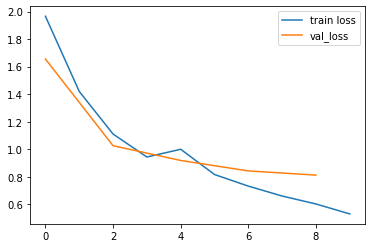

In [52]:
plt.plot(train_losses, label='train loss')
plt.plot(np.arange(0,config['val_epochs']*len(val_losses),config['val_epochs']),val_losses, label='val_loss')
plt.legend()

In [53]:
preds = []
gts = []
for (X,y) in tqdm.tqdm(testloader):
  X = X.to(device)
  yhat = resnet(X).argmax(axis=1).tolist()
  preds += yhat
  gts += y.tolist()
preds = np.array(preds)
gts = np.array(gts)

100%|██████████| 157/157 [00:04<00:00, 38.25it/s]


In [54]:
(preds==gts).mean()

0.7348